In [20]:

import common_functions as cf
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage import io, color, filters, morphology, measure, exposure
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import math

# Preprocessing


In [21]:


# Optimal Thresholding Function
def optimalThresholding(image):
    img = (cf.rgb2gray(image) if len(image.shape) > 2 else image).copy()
    img = (img / img.max() * 255).astype(np.uint8)

    counts = np.bincount(img.ravel(), minlength=256)
    total_pixels = img.size
    Tnew = np.dot(np.arange(256), counts) // total_pixels

    while True:
        below = np.arange(Tnew)
        above = np.arange(Tnew, 256)
        sum1, count1 = np.dot(counts[below], below), counts[below].sum() or 1
        sum2, count2 = np.dot(counts[above], above), counts[above].sum() or 1
        Tnext = round((sum1 / count1 + sum2 / count2) / 2)
        if Tnext == Tnew:
            break
        Tnew = Tnext

    img = np.where(img < Tnew, 0, 255).astype(np.uint8)
    return img

# Local Thresholding Function
def LocalThresholding(in_image, num_blocks=(2, 2)):
    img = in_image.copy()
    if len(img.shape) > 2:
        img = cf.rgb2gray(img)

    rows, cols = img.shape
    block_rows, block_cols = num_blocks
    row_step, col_step = rows // block_rows, cols // block_cols

    for i in range(block_rows):
        for j in range(block_cols):
            start_row, end_row = i * row_step, (i + 1) * row_step if i < block_rows - 1 else rows
            start_col, end_col = j * col_step, (j + 1) * col_step if j < block_cols - 1 else cols

            block = img[start_row:end_row, start_col:end_col]
            img[start_row:end_row, start_col:end_col] = optimalThresholding(block)

    return img

# Function to Detect the Star Line and Bounding Box
def detect_star_line(img):
    # Apply Canny edge detection
    edges = cf.canny(image=img, sigma=1, low_threshold=0.1, high_threshold=0.3)

    edges = (edges * 255).astype(np.uint8)  # Convert True to 255 and False to 0

    # Use Hough Transform to detect straight lines
    lines = cv2.HoughLines(edges.astype(np.uint8), 1, np.pi / 180, 100)
    bounding_box = None

    if lines is not None:
        # Use the first detected line
        rho, theta = lines[0][0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # Calculate bounding box around the detected line
        card_height = 100  # Adjust as needed
        card_width = 200
        pt_top_left = (int(x0 - card_width / 2), int(y0 - card_height / 2))
        pt_bottom_right = (int(x0 + card_width / 2), int(y0 + card_height / 2))
        bounding_box = (pt_top_left, pt_bottom_right)

        # Draw the bounding box on the image
        cv2.rectangle(img, pt_top_left, pt_bottom_right, (0, 0, 0), 2)

    return img, bounding_box



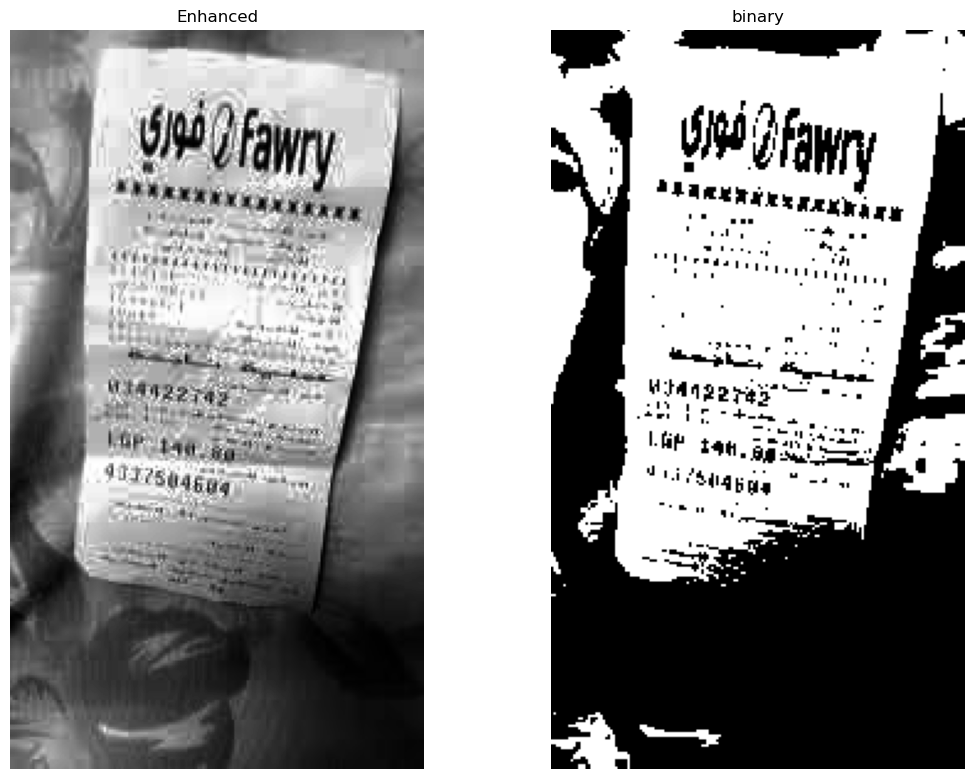

Bounding box coordinates: ((-67, -48), (132, 51))


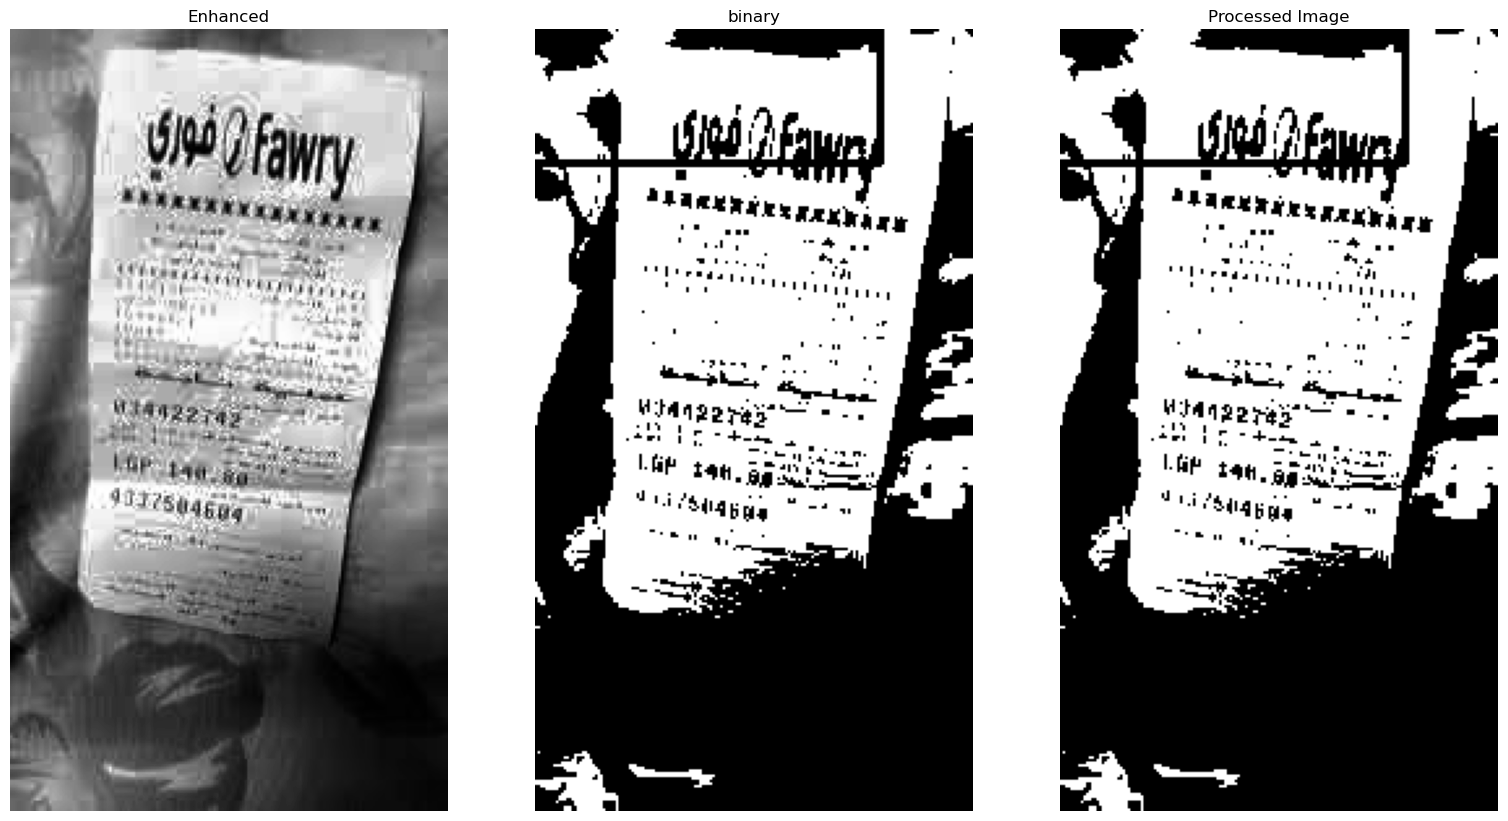

In [22]:

# Main Processing Pipeline
image = io.imread("../imgs/5.jpg")

# Convert to grayscale and normalize
gray = cf.rgb2gray(image)
gray = gray / np.max(gray)  # Normalize to [0, 1]

# Enhance contrast
enhanced = exposure.equalize_hist(gray)

binary = np.where (enhanced > 0.5, 1, 0)
cf.show_images([enhanced, binary], ["Enhanced", "binary"])
# Detect the star line and bounding box
processed_img, bbox = detect_star_line(binary)

if bbox:
    print(f"Bounding box coordinates: {bbox}")

# Display results
cf.show_images([enhanced, processed_img,binary], ["Enhanced", "binary","Processed Image"])


In [23]:
# Load and preprocess the image
image = io.imread('../imgs/4.jpg')
gray = color.rgb2gray(image)
enhanced = exposure.equalize_hist(gray)
binary = enhanced > filters.threshold_otsu(enhanced)

# Morphological operations
selem = morphology.disk(2)
cleaned = morphology.binary_opening(binary, selem)


edges =cf.canny(binary, 50, 150)  # Detect edges

contours = measure.find_contours(cleaned, level=0.5)

if contours:
    largest_contour = max(contours, key=lambda x: measure.approximate_polygon(x, tolerance=2).shape[0])
    min_row, min_col = np.min(largest_contour, axis=0)
    max_row, max_col = np.max(largest_contour, axis=0)
    receipt = image[int(min_row):int(max_row), int(min_col):int(max_col)]
cf.show_images([image, gray, enhanced,edges], ['Original', 'Gray', 'Enhanced','edges'])


ValueError: low_threshold should be lower then high_threshold

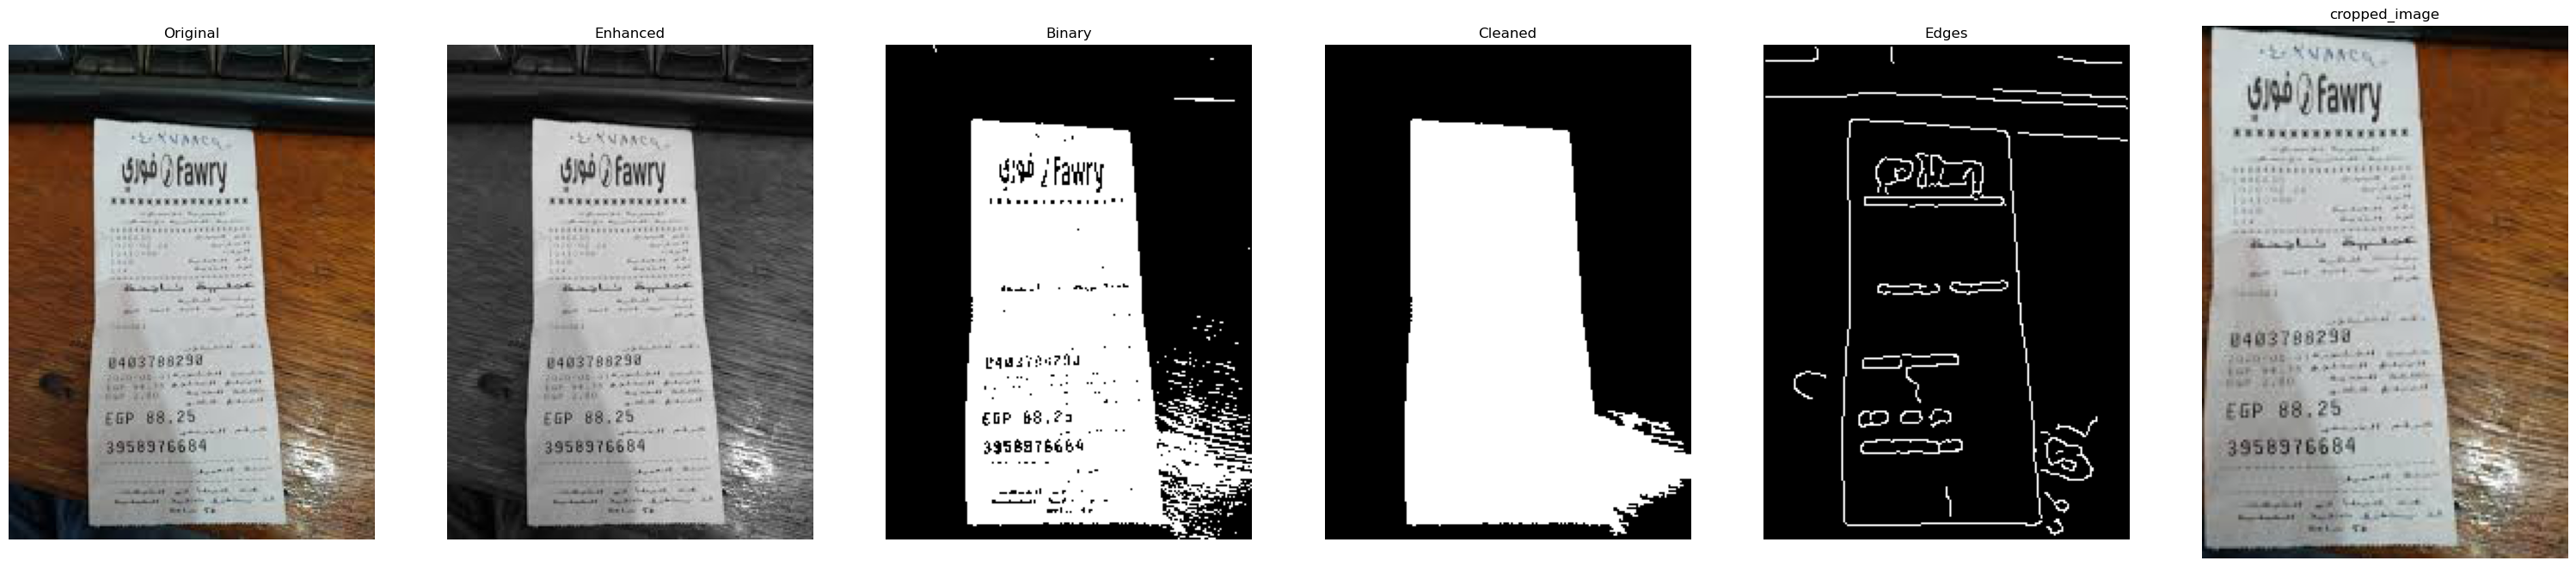

0.6863636363636364

In [30]:
# working images : 1,2,3,4
# not working images : 5,6 ,7 ,8

# Load the image
image = io.imread('../imgs/8.jpg')

# Convert to grayscale
gray = cf.rgb2gray(image)

# Enhance contrast using histogram equalization : Histogram bta3et el lab mesh shghala leh ?
# enhanced = exposure.equalize_hist(gray)
enhanced = gray
##enhanced =  preprocess_image(image)

# Apply Otsu's thresholding : will be implemented bas hagarabo 
thresh_val = filters.threshold_otsu(enhanced)
binary = enhanced > thresh_val  # Invert if needed: binary = enhanced <= thresh_val

cleaned = morphology.remove_small_holes(binary, area_threshold=500)
cleaned = morphology.remove_small_objects(cleaned, min_size=500)

# Edge detection
# edges = cf.canny(cleaned, sigma=2)
edges = cf.canny(enhanced, sigma=2)

# Find contours
# contours = measure.find_contours(cleaned, level=0.5)
contours = measure.find_contours(cleaned, level=0.5)

# Select the largest contour (assumed to be the receipt)
largest_contour = max(contours, key=lambda x: measure.approximate_polygon(x, tolerance=2).shape[0])

# Get bounding box for the receipt
min_row, min_col = np.min(largest_contour, axis=0)
max_row, max_col = np.max(largest_contour, axis=0) 
# Calculate correceted bounding box
# Crop the receipt using corrected bounding box
#receipt_corrected = image[int(ymin):int(ymax), int(xmin):int(xmax)]

# Crop the receipt
receipt = image[int(min_row):int(max_row), int(min_col):int(max_col)]

cf.show_images([image, enhanced, binary, cleaned, edges,receipt], ['Original', 'Enhanced', 'Binary', 'Cleaned', 'Edges','cropped_image'])
Y, X, _ = receipt.shape
X/Y

51


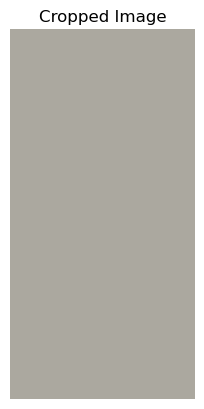

In [ ]:
from skimage.draw import rectangle

bounding_boxes =[]
for contour in contours : 
    x_min = np.min(contour[:, 1])
    x_max = np.max(contour[:, 1])
    y_min = np.min(contour[:, 0])
    y_max = np.max(contour[:, 0])

    bounding_box = [x_min, x_max, y_min, y_max]

    horizontal = x_max - x_min
    vertical = y_max - y_min

    detected_aspect_ratio = horizontal/vertical

    if (detected_aspect_ratio >=  0.5) and (detected_aspect_ratio <=  0.6) :
        bounding_boxes.append(bounding_box)

print(len(bounding_boxes))
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    cropped_receipt = image[int(Ymin):int(Ymax), int(Xmin):int(Xmax)]
    
cf.show_images([cropped_receipt],["Cropped Image",])